In [1]:
__depends__ = [
    "../../../data/database-results/phase-1/timestamp.txt",
    "../../../data/database-observations/timestamp.txt",
]
__dest__ = ["../../../figures/probabilistic-projections.pdf"]

In [2]:
PROBABILISTIC_PROJECTIONS_FIGURE_PDF = __dest__[0]

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
%load_ext autoreload

%autoreload 2

<IPython.core.display.Javascript object>

# Probabilistic projections

In [5]:
import glob
import logging
import os
import re
from distutils.util import strtobool
from pathlib import Path

import numpy as np
import pandas as pd
import tqdm

from pymagicc.io import MAGICCData
from scmdata import ScmRun, ScmDataFrame
from scmdata.run import df_append

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns

%matplotlib inline

<IPython.core.display.Javascript object>

In [6]:
from utils import (
    clean_label,
    clean_labels,
    convert_scmdf_to_pyamdf_year_only,
    load_database_files,
    prep_str_for_filename,
    reduce_to_one_variant_per_model,
)

/Users/znicholls/Documents/AGCEC/RCMIP/rcmip/notebooks/results/phase-1/utils.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


<IPython.core.display.Javascript object>

In [7]:
TEST_RUN = strtobool(os.getenv("CI", "False")) or False
TEST_RUN

False

<IPython.core.display.Javascript object>

In [8]:
logger = logging.getLogger()

<IPython.core.display.Javascript object>

In [9]:
PYAM_COLORS = {
    # AR6 colours from https://github.com/IPCC-WG1/colormaps
    # where each file is processed to generate hex values, e.g.:
    # for liwith open('rcp_cat.txt') as f:
    #   for l in f.readlines():
    #     rgb = np.array([int(x) for x in l.strip().split()]) / 256
    #     print(matplotlib.colors.rgb2hex(rgb))
    "AR6-SSP1": "#1e9583",
    "AR6-SSP2": "#4576be",
    "AR6-SSP3": "#f11111",
    "AR6-SSP4": "#e78731",
    "AR6-SSP5": "#8036a7",
    "AR6-SSP1-1.9": "#1e9583",
    "AR6-SSP1-2.6": "#1d3354",
    "AR6-SSP2-4.5": "#e9dc3d",
    "AR6-SSP3-7.0": "#f11111",
    "AR6-SSP3-LowNTCF": "#f11111",
    "AR6-SSP4-3.4": "#63bce4",
    "AR6-SSP4-6.0": "#e78731",
    "AR6-SSP5-3.4-OS": "#996dc8",
    "AR6-SSP5-8.5": "#830b22",
    "AR6-RCP-2.6": "#980002",
    "AR6-RCP-4.5": "#c37900",
    "AR6-RCP-6.0": "#709fcc",
    "AR6-RCP-8.5": "#003466",
    # AR5 colours from
    # https://tdaviesbarnard.co.uk/1202/ipcc-official-colors-rcp/
    "AR5-RCP-2.6": "#0000FF",
    "AR5-RCP-4.5": "#79BCFF",
    "AR5-RCP-6.0": "#FF822D",
    "AR5-RCP-8.5": "#FF0000",
}

color_map_scenarios_base = {
    "ssp119": "AR6-SSP1-1.9",
    "ssp126": "AR6-SSP1-2.6",
    "ssp245": "AR6-SSP2-4.5",
    "ssp370": "AR6-SSP3-7.0",
    "ssp370-lowNTCF": "AR6-SSP3-LowNTCF",
    "ssp370-lowNTCF-gidden": "AR6-SSP3-LowNTCF",
    "ssp370-lowNTCF-aerchemmip": "AR6-SSP3-LowNTCF",
    "ssp434": "AR6-SSP4-3.4",
    "ssp460": "AR6-SSP4-6.0",
    "ssp585": "AR6-SSP5-8.5",
    "ssp534-over": "AR6-SSP5-3.4-OS",
    "historical": "black",
    "rcp26": "AR5-RCP-2.6",
    "rcp45": "AR5-RCP-4.5",
    "rcp60": "AR5-RCP-6.0",
    "rcp85": "AR5-RCP-8.5",
    "historical-cmip5": "tab:gray",
}

color_map_scenarios = {}
for k, v in color_map_scenarios_base.items():
    try:
        color_map_scenarios[k] = PYAM_COLORS[v]
        color_map_scenarios["esm-{}".format(k)] = PYAM_COLORS[v]
        color_map_scenarios["esm-{}-allGHG".format(k)] = PYAM_COLORS[v]
    except KeyError:
        color_map_scenarios[k] = v
        color_map_scenarios["esm-{}".format(k)] = v
        color_map_scenarios["esm-{}-allGHG".format(k)] = v

<IPython.core.display.Javascript object>

In [10]:
color_map_models = {"Observations (Priestley Centre)": "black"}

<IPython.core.display.Javascript object>

## Load data

### Observations

In [11]:
OBS_PATH = os.path.join("..", "..", "..", "data", "database-observations")
OBS_PATH

'../../../data/database-observations'

<IPython.core.display.Javascript object>

In [12]:
db_obs = df_append(
    [ScmRun.from_nc(f) for f in glob.glob(os.path.join(OBS_PATH, "*.nc"))]
)
db_obs.timeseries().head()

time                                                                                               1850-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K      -0.042412   

time                                                                                               1851-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K       0.123588   

time                                                                                               1852-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K       0.085588   

time                                                                                               1853-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K       0.025588   

time                                                                                               1854-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K       0.086588   

time                                                                                               1855-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K       0.087588   

time                                                                                               1856-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K      -0.040412   

time                                                                                               1857-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K      -0.138412   

time                                                                                               1858-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K      -0.074412   

time                                                                                               1859-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K      -0.012412   

time                                                                                               ...  \
region model       scenario   climatemodel                    variable                       unit  ...   
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K     ...   

time                                                                                               2009-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley C

<IPython.core.display.Javascript object>

### RCMIP results

In [13]:
RESULTS_PATH = os.path.join("..", "..", "..", "data", "database-results", "phase-1")
RESULTS_PATH

'../../../data/database-results/phase-1'

<IPython.core.display.Javascript object>

In [14]:
model_of_interest = [
    ".*acc2.*",
    ".*cicero-scm.*",
    #     ".*escimo.*",
    ".*fair-1.5.*",
    #     ".*gir.*",
    #     ".*greb.*",
    ".*hector.*",
    #     ".*magicc7.*",
    ".*mce.*",
    ".*oscar.*",
    ".*umd-emgc.*",
    ".*wasp.*prob-hist.*",
]

results_files = list(Path(RESULTS_PATH).rglob("*.nc"))
results_files = [
    str(p)
    for p in results_files
    if any([bool(re.match(m, str(p))) for m in model_of_interest]) and "$" not in str(p)
]
print("Number of available files: {}".format(len(results_files)))
results_files[:5]

Number of available files: 3098


['../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_effective-radiative-forcing-anthropogenic-f-gases-pfc-cf4.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_radiative-forcing-anthropogenic-tropospheric-ozone.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_fair-1.5-ens_world_atmospheric-concentrations-f-gases-pfc-cf4-50th-quantile.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_wasp,2,prob-hist_world_surface-ocean-temperature-change-90th-quantile.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm_world_effective-radiative-forcing-anthropogenic-albedo-change.nc']

<IPython.core.display.Javascript object>

In [15]:
variables_of_interest = [
    ".*surface-air-temperature-change.*quantile.*",
    ".*radiative-forcing-\d.*quantile.*",
    ".*radiative-forcing-anthropogenic-aerosols-\d.*quantile.*",
    ".*radiative-forcing-anthropogenic-co2-\d.*quantile.*",
]

relevant_files = [
    str(p)
    for p in results_files
    if any([bool(re.match(v, str(p))) for v in variables_of_interest])
]
print("Number of relevant files: {}".format(len(relevant_files)))
relevant_files[:5]

Number of relevant files: 167


['../../../data/database-results/phase-1/rcmip-phase-1_umd-emgc,5,prob_world_surface-air-temperature-change-83th-quantile.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_oscarv3.1_world_radiative-forcing-anthropogenic-co2-16th-quantile.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_umd-emgc,5,prob_world_surface-air-temperature-change-10th-quantile.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_hector-1d51f-histcalib_world_surface-air-temperature-change-97.5th-quantile.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_hector-1d51f-histcalib_world_radiative-forcing-10th-quantile.nc']

<IPython.core.display.Javascript object>

In [16]:
logging.getLogger("scmdata").setLevel(logging.WARNING)
db = load_database_files(relevant_files)
logging.getLogger("scmdata").setLevel(logging.INFO)
db.head()

time                                                                                                           1750-01-01 00:00:00  \
region model          scenario climatemodel    variable                                     unit_context unit                        
World  Not_applicable ssp119   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   
                      ssp126   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   
                      ssp245   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   
                      ssp370   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   
                      ssp434   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   

time                                                                                                           1751-01-01 00:00:00  \
region model          scenario climatemodel    variable                                     unit_context unit                        
World  Not_applicable ssp119   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   
                      ssp126   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   
                      ssp245   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   
                      ssp370   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   
                      ssp434   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   

time                                                                                                           1752-01-01 00:00:00  \
region model          scenario climatemodel    variable                                     unit_context unit                        
World  Not_applicable ssp119   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   
                      ssp126   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   
                      ssp245   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   
                      ssp370   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   
                      ssp434   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   

time                                                                                                           1753-01-01 00:00:00  \
region model          scenario climatemodel    variable                                     unit_context unit                        
World  Not_applicable ssp119   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   
                      ssp126   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   
                      ssp245   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   
                      ssp370   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   
                      ssp434   UMD-EMGC,5,PROB Surface Air Temperature Change|83th quantile not_required K                     NaN   

time                                                                                                           1754-01-01 00:00:00  \
region model          scenario climatemodel    variable                                     unit_context unit 

<IPython.core.display.Javascript object>

## Get consistent quantiles

In [17]:
db["variable"].unique()

array(['Surface Air Temperature Change|83th quantile',
       'Radiative Forcing|Anthropogenic|CO2|16th quantile',
       'Surface Air Temperature Change|10th quantile',
       'Surface Air Temperature Change|97.5th quantile',
       'Radiative Forcing|10th quantile',
       'Surface Air Temperature Change|17th quantile',
       'Radiative Forcing|Anthropogenic|Aerosols|97.5th quantile',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|50th quantile',
       'Radiative Forcing|90th quantile',
       'Surface Air Temperature Change|90th quantile',
       'Surface Air Temperature Change|67th quantile',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|100th quantile',
       'Radiative Forcing|Anthropogenic|Aerosols|75th quantile',
       'Effective Radiative Forcing|Anthropogenic|CO2|90th quantile',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|33th quantile',
       'Radiative Forcing|Anthropogenic|CO2|95th quantile',
       'Surface Air Temperature Chan

<IPython.core.display.Javascript object>

In [18]:
def get_quantile(raw_var):
    try:
        return float(re.findall(".*\|(\S*)th.*", raw_var)[0])
    except IndexError:
        print(raw_var)
        raise


db_quantiles = db.timeseries().reset_index()
assert db_quantiles["variable"].apply(lambda x: "quantile" in x).all()
db_quantiles["quantile"] = db_quantiles["variable"].apply(get_quantile)
assert not db_quantiles["quantile"].isnull().any()
db_quantiles["variable"] = db_quantiles["variable"].apply(
    lambda x: "|".join(x.split("|")[:-1])
)
db_quantiles = ScmDataFrame(db_quantiles).timeseries().stack().unstack("quantile")
db_quantiles = db_quantiles.interpolate(method="index", axis=1)

for c in [0.0, 100.0]:
    if c in db_quantiles:
        db_quantiles = db_quantiles.drop(c, axis="columns")
db_quantiles.head()

/Users/znicholls/miniconda3/envs/rcmip/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: ScmDataFrame has been deprecated and will be removed in v0.6.0. Use the ScmRun class instead
  app.launch_new_instance()


quantile                                                                                               2.5   \
model scenario region variable                    unit  climatemodel unit_context time                        
AIM   rcp60    World  Effective Radiative Forcing W/m^2 OSCARv3.1    not_required 1850-01-01 00:00:00   NaN   
                                                                                  1851-01-01 00:00:00   NaN   
                                                                                  1852-01-01 00:00:00   NaN   
                                                                                  1853-01-01 00:00:00   NaN   
                                                                                  1854-01-01 00:00:00   NaN   

quantile                                                                                               5.0   \
model scenario region variable                    unit  climatemodel unit_context time                        
AIM   rcp60    World  Effective Radiative Forcing W/m^2 OSCARv3.1    not_required 1850-01-01 00:00:00   NaN   
                                                                                  1851-01-01 00:00:00   NaN   
                                                                                  1852-01-01 00:00:00   NaN   
                                                                                  1853-01-01 00:00:00   NaN   
                                                                                  1854-01-01 00:00:00   NaN   

quantile                                                                                               10.0  \
model scenario region variable                    unit  climatemodel unit_context time                        
AIM   rcp60    World  Effective Radiative Forcing W/m^2 OSCARv3.1    not_required 1850-01-01 00:00:00   NaN   
                                                                                  1851-01-01 00:00:00   NaN   
                                                                                  1852-01-01 00:00:00   NaN   
                                                                                  1853-01-01 00:00:00   NaN   
                                                                                  1854-01-01 00:00:00   NaN   

quantile                                                                                                   16.0  \
model scenario region variable                    unit  climatemodel unit_context time                            
AIM   rcp60    World  Effective Radiative Forcing W/m^2 OSCARv3.1    not_required 1850-01-01 00:00:00  0.095726   
                                                                                  1851-01-01 00:00:00  0.130103   
                                                                                  1852-01-01 00:00:00  0.121705   
                                                                                  1853-01-01 00:00:00  0.118813   
                                                                                  1854-01-01 00:00:00  0.074357   

quantile                                                                                                   17.0  \
model scenario region variable                    unit  climatemodel unit_context time                            
AIM   rcp60    World  Effective Radiative Forcing W/m^2 OSCARv3.1    not_required 1850-01-01 00:00:00  0.097407   
                                                                                  1851-01-01 00:00:00  0.131840   
                                                                                  1852-01-01 00:00:00  0.123475   
                                                                                  1853-01-01 00:00:00  0.120608   
                                                                                  1854-01-01 00:00:00  0.076173   

quantile                                              

<IPython.core.display.Javascript object>

In [19]:
db_quantiles = ScmRun(db_quantiles.stack().unstack("time"))
db_quantiles.head()

time                                                                                        1850-01-01 00:00:00  \
model scenario region variable                    unit  unit_context climatemodel quantile                        
AIM   rcp60    World  Effective Radiative Forcing W/m^2 not_required OSCARv3.1    16.0                 0.095726   
                                                                                  17.0                 0.097407   
                                                                                  25.0                 0.110857   
                                                                                  33.0                 0.124307   
                                                                                  50.0                 0.152888   

time                                                                                        1851-01-01 00:00:00  \
model scenario region variable                    unit  unit_context climatemodel quantile                        
AIM   rcp60    World  Effective Radiative Forcing W/m^2 not_required OSCARv3.1    16.0                 0.130103   
                                                                                  17.0                 0.131840   
                                                                                  25.0                 0.145738   
                                                                                  33.0                 0.159636   
                                                                                  50.0                 0.189170   

time                                                                                        1852-01-01 00:00:00  \
model scenario region variable                    unit  unit_context climatemodel quantile                        
AIM   rcp60    World  Effective Radiative Forcing W/m^2 not_required OSCARv3.1    16.0                 0.121705   
                                                                                  17.0                 0.123475   
                                                                                  25.0                 0.137631   
                                                                                  33.0                 0.151787   
                                                                                  50.0                 0.181869   

time                                                                                        1853-01-01 00:00:00  \
model scenario region variable                    unit  unit_context climatemodel quantile                        
AIM   rcp60    World  Effective Radiative Forcing W/m^2 not_required OSCARv3.1    16.0                 0.118813   
                                                                                  17.0                 0.120608   
                                                                                  25.0                 0.134967   
                                                                                  33.0                 0.149326   
                                                                                  50.0                 0.179838   

time                                                                                        1854-01-01 00:00:00  \
model scenario region variable                    unit  unit_context climatemodel quantile                        
AIM   rcp60    World  Effective Radiative Forcing W/m^2 not_required OSCARv3.1    16.0                 0.074357   
                                                                                  17.0                 0.076173   
                                                                                  25.0                 0.090701   
                                                                                  33.0                 0.105230   
                                                                                  50.0

<IPython.core.display.Javascript object>

## Plot

In [20]:
sorted(db_quantiles["quantile"].unique())

[2.5,
 5.0,
 10.0,
 16.0,
 17.0,
 25.0,
 33.0,
 50.0,
 67.0,
 75.0,
 83.0,
 84.0,
 90.0,
 95.0,
 97.5]

<IPython.core.display.Javascript object>

In [21]:
db_quantiles["climatemodel"].unique()

array(['OSCARv3.1', 'hector|1d51f|HISTCALIB', 'MCE,v1-1,PROB',
       'UMD-EMGC,5,PROB', 'FaIR-1.5-ENS', 'WASP,2,PROB-hist'],
      dtype=object)

<IPython.core.display.Javascript object>

In [22]:
db_quantiles.filter(climatemodel="*hector*")["quantile"].unique()

array([ 2.5,  5. , 10. , 16. , 17. , 25. , 33. , 50. , 67. , 75. , 83. ,
       84. , 90. , 95. , 97.5])

<IPython.core.display.Javascript object>

In [23]:
db_quantiles.filter(climatemodel="*OSCAR*", variable="Effective Radiative Forcing*")[
    "scenario"
].unique()

array(['rcp60', 'ssp370', 'ssp370-lowNTCF-aerchemmip', 'ssp434', 'ssp460',
       'rcp26', 'ssp119', 'ssp126', 'rcp85', 'ssp245', 'rcp45',
       'ssp534-over', 'ssp585', '1pctCO2', '1pctCO2-4xext', '1pctCO2-bgc',
       '1pctCO2-cdr', '1pctCO2-rad', 'abrupt-0p5xCO2', 'abrupt-2xCO2',
       'abrupt-4xCO2', 'esm-1pct-brch-1000PgC', 'esm-1pct-brch-2000PgC',
       'esm-1pct-brch-750PgC', 'esm-1pctCO2', 'esm-bell-1000PgC',
       'esm-bell-2000PgC', 'esm-bell-750PgC', 'esm-hist',
       'esm-hist-cmip5', 'esm-pi-CO2pulse', 'esm-pi-cdr-pulse',
       'esm-piControl', 'esm-rcp26', 'esm-rcp45', 'esm-rcp60',
       'esm-rcp85', 'esm-ssp119', 'esm-ssp126', 'esm-ssp245',
       'esm-ssp370', 'esm-ssp370-lowNTCF-aerchemmip',
       'esm-ssp370-lowNTCF-gidden', 'esm-ssp434', 'esm-ssp460',
       'esm-ssp534-over', 'esm-ssp585', 'esm-ssp585-ssp126Lu',
       'esm-yr2010CO2-CO2pulse', 'esm-yr2010CO2-cdr-pulse',
       'esm-yr2010CO2-noemit', 'hist-CO2', 'hist-GHG', 'hist-aer',
       'hist-bgc', 'h

<IPython.core.display.Javascript object>

In [24]:
db_quantiles["variable"].unique()

array(['Effective Radiative Forcing',
       'Effective Radiative Forcing|Anthropogenic|Aerosols',
       'Radiative Forcing', 'Radiative Forcing|Anthropogenic|Aerosols',
       'Radiative Forcing|Anthropogenic|CO2',
       'Surface Air Temperature Change',
       'Effective Radiative Forcing|Anthropogenic|CO2'], dtype=object)

<IPython.core.display.Javascript object>

Shift the EMGC data back to desired baseline. This probably isn't how it should be done cause all the quantiles blend but ok for sample results.

In [25]:
emgc_data = db_quantiles.filter(climatemodel="*EMGC*")
db_quantiles = db_quantiles.filter(climatemodel="*EMGC*", keep=False).append(
    emgc_data.relative_to_ref_period_mean(year=range(1850, 1900))
)

<IPython.core.display.Javascript object>

In [26]:
matplotlib.rcParams["figure.figsize"] = (16, 24)
matplotlib.rcParams["font.size"] = 6

<IPython.core.display.Javascript object>

In [27]:
PROBABILISTIC_PROJECTIONS_FIGURE_PDF

'../../../figures/probabilistic-projections.pdf'

<IPython.core.display.Javascript object>

In [28]:
db_quantiles["climatemodel"].unique()

array(['OSCARv3.1', 'hector|1d51f|HISTCALIB', 'MCE,v1-1,PROB',
       'FaIR-1.5-ENS', 'WASP,2,PROB-hist', 'UMD-EMGC,5,PROB'],
      dtype=object)

<IPython.core.display.Javascript object>

['OSCARv3.1', 'hector|1d51f|HISTCALIB', 'MCE,v1-1,PROB', 'FaIR-1.5-ENS', 'WASP,2,PROB-hist', 'UMD-EMGC,5,PROB']
../../../figures/probabilistic-projections-surface-air-temperature-change.pdf


Filtered ScmRun is empty!
Filtered ScmRun is empty!


['OSCARv3.1', 'MCE,v1-1,PROB', 'FaIR-1.5-ENS', 'WASP,2,PROB-hist']


Filtered ScmRun is empty!
Filtered ScmRun is empty!


../../../figures/probabilistic-projections-effective-radiative-forcing.pdf


Filtered ScmRun is empty!
Filtered ScmRun is empty!


['OSCARv3.1', 'FaIR-1.5-ENS', 'WASP,2,PROB-hist']


Filtered ScmRun is empty!


../../../figures/probabilistic-projections-effective-radiative-forcing|anthropogenic|aerosols.pdf


Filtered ScmRun is empty!


['FaIR-1.5-ENS', 'WASP,2,PROB-hist']


Filtered ScmRun is empty!


../../../figures/probabilistic-projections-effective-radiative-forcing|anthropogenic|co2.pdf


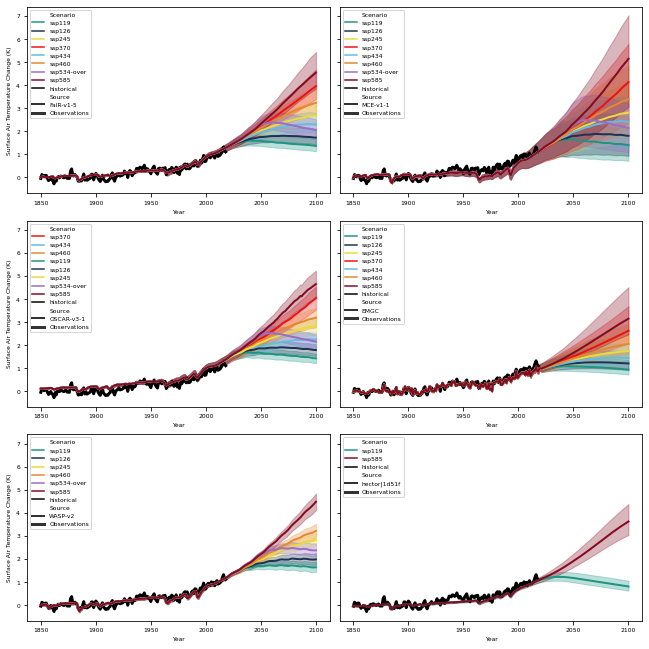

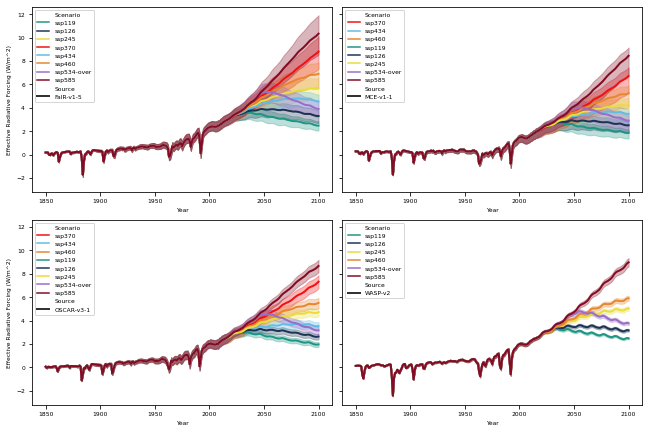

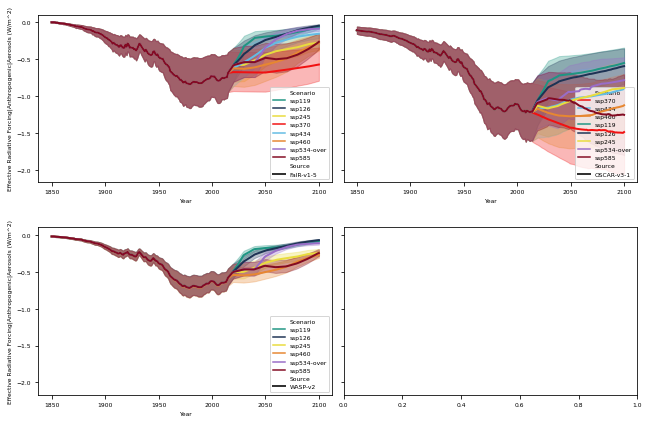

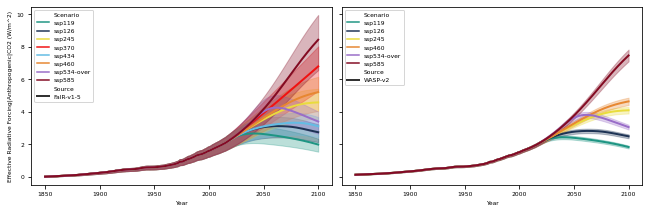

<IPython.core.display.Javascript object>

In [39]:
# plt_years = range(1850, 2101)
scenarios_to_plot = [
    "ssp119",
    "ssp126",
    "ssp245",
    "ssp370",
    "ssp434",
    "ssp460",
    "ssp585",
    "ssp534-over",
]
variables = [
    "Surface Air Temperature Change",
    "Effective Radiative Forcing",
    "Effective Radiative Forcing|Anthropogenic|Aerosols",
    "Effective Radiative Forcing|Anthropogenic|CO2",
]

for variable in variables:
    db_var = db_quantiles.filter(
        variable=variable, scenario=scenarios_to_plot, year=plt_years
    )
    climatemodels = db_var.get_unique_meta("climatemodel")
    print(climatemodels)
    ncols = 2
    nrows = int(np.ceil(len(climatemodels) / 2))
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, sharey=True, figsize=(9, 3 * nrows)
    )
    axes = axes.flatten()

    for ax, climatemodel in zip(axes, sorted(climatemodels)):
        dbcm = db_var.filter(climatemodel=climatemodel, scenario=scenarios_to_plot)
        if dbcm.empty:
            continue
        dbcm["Source"] = climatemodel
        dbcm_median = dbcm.filter(quantile=50.0).long_data(time_axis="year")

        dbobs = db_obs.filter(variable=variable)
        if dbobs.empty:
            dbplt = pd.concat([dbcm_median])

        else:
            dbobs["Source"] = "Observations"
            dbobs = dbobs.long_data(time_axis="year")
            dbplt = pd.concat([dbcm_median, dbobs])

        dbplt["Scenario"] = dbplt["scenario"]

        sizes = {"Observations": 3, climatemodel: 2}
        sns.lineplot(
            data=dbplt,
            x="time",
            y="value",
            ax=ax,
            legend="brief",
            palette=color_map_scenarios,
            hue="Scenario",
            units="climatemodel",
            estimator=None,
            size="Source",
            sizes=sizes,
        )
        for db_scenario in dbcm.groupby("scenario"):
            ax.fill_between(
                db_scenario["year"],
                db_scenario.filter(quantile=17.0).values.squeeze(),
                db_scenario.filter(quantile=83.0).values.squeeze(),
                color=color_map_scenarios[
                    db_scenario.get_unique_meta("scenario", no_duplicates=True)
                ],
                alpha=0.3,
                zorder=1.9,
            )

        ax.set_ylabel(
            "{} ({})".format(
                variable, db_var.get_unique_meta("unit", no_duplicates=True)
            )
        )
        ax.set_xlabel("Year")
        clean_labels(
            ax, ignore=["Source", "Scenario", "historical"] + scenarios_to_plot
        )
        ax.legend(loc="upper left" if "Aerosols" not in variable else "lower right")

        for l in ax.get_lines():
            if l.get_color() == "black":
                l.set_zorder(10)
            else:
                l.set_zorder(11)

    plt.tight_layout()
    outfile = PROBABILISTIC_PROJECTIONS_FIGURE_PDF.replace(
        ".pdf", "-{}.pdf".format(variable.lower().replace(" ", "-")).replace("$", "")
    )
    fig.savefig(outfile)
    print(outfile)

In [37]:
dir(l)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_animated',
 '_antialiased',
 '_axes',
 '_clipon',
 '_clippath',
 '_color',
 '_contains',
 '_dashOffset',
 '_dashSeq',
 '_dashcapstyle',
 '_dashjoinstyle',
 '_default_contains',
 '_drawStyles_l',
 '_drawStyles_s',
 '_drawstyle',
 '_get_clipping_extent_bbox',
 '_get_markerfacecolor',
 '_get_transformed_path',
 '_gid',
 '_in_layout',
 '_invalidx',
 '_invalidy',
 '_is_sorted',
 '_label',
 '_lineStyles',
 '_linestyle',
 '_linestyles',
 '_linewidth',
 '_marker',
 '_markeredgecolor',
 '_markeredgewidth',
 '_markerfacecolor',
 '_markerfacecoloralt',
 '_markersize',
 '_m

<IPython.core.display.Javascript object>

In [36]:
l.get_color()

'.2'

<IPython.core.display.Javascript object>